<a href="https://colab.research.google.com/github/Akeshh/ICS661-Assignment1/blob/main/ICS661_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Split features and labels
train_features = train_df.iloc[:, 1:].values  # all columns except the first (features)
train_labels = train_df.iloc[:, 0].values     # first column (labels)

eval_features = test_df.iloc[:, 1:].values
eval_labels = test_df.iloc[:, 0].values

# Convert the data to PyTorch tensors
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)  # long for classification labels

eval_features_tensor = torch.tensor(eval_features, dtype=torch.float32)
eval_labels_tensor = torch.tensor(eval_labels, dtype=torch.long)

# Create TensorDataset for PyTorch
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
eval_dataset = TensorDataset(eval_features_tensor, eval_labels_tensor)

# Create DataLoader for batching
batch_size = 32  # You can adjust the batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

# You can now use train_loader and eval_loader in your training loop


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the MLP model with corrected output size
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_fn):
        super(MLP, self).__init__()

        # Store the activation function
        self.activation_fn = activation_fn

        # Input layer
        layers = []
        prev_size = input_size  # Ensure this is correctly matched to the feature size

        # Hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))  # Add batch normalization
            layers.append(self.activation_fn)           # Add activation function
            layers.append(nn.Dropout(0.2))              # Add dropout
            prev_size = hidden_size

        # Output layer: Change output_size to 10 for 10 classes
        layers.append(nn.Linear(prev_size, output_size))  # output_size should be 10 for 10 classes

        # Build the model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Example model initialization with output size of 10 classes
input_size = 784  # Number of features
hidden_sizes = [512, 256, 128, 64]
output_size = 10  # 10 classes



In [4]:
import torch.optim as optim

# Define the get_optimizer function
def get_optimizer(optimizer_name, model, learning_rate):
    if optimizer_name == 'Adam':
        return optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'AdamW':
        return optim.AdamW(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD':
        return optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    else:
        raise ValueError("Unsupported optimizer. Choose from 'Adam', 'AdamW', or 'SGD'.")



In [5]:
# Define activation function
activation_fn = nn.ReLU()

model = MLP(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size, activation_fn=activation_fn)
# Check if a GPU is available and use it; otherwise, fall back to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")



# Define loss function (criterion) for classification
criterion = nn.CrossEntropyLoss()
# Example usage
optimizer_name = 'AdamW'  # You can choose 'Adam', 'AdamW', or 'SGD'
learning_rate = 1e-02
optimizer = get_optimizer(optimizer_name, model, learning_rate)
  # Choose your activation function

# Move the model to the device (GPU or CPU)
model = model.to(device)
print(model)  # Check the model structure

Using device: cuda
MLP(
  (activation_fn): ReLU()
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [7]:
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import numpy as np
from tqdm import tqdm

# Evaluation function for the validation set
def evaluate_model(model, eval_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    eval_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in eval_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            eval_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Calculate accuracy, F1 score, precision, and recall
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    # Print classification report to see precision and recall for each class
    print(classification_report(all_labels, all_preds))

    return eval_loss / len(eval_loader), acc, f1, precision, recall

# Visualization function to plot metrics at the end of training
def plot_metrics(steps, accuracies, f1_scores, losses):
    plt.figure(figsize=(15, 5))

    # Plot accuracy
    plt.subplot(1, 3, 1)
    plt.plot(steps, accuracies, label='Accuracy', color='blue', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.grid(True)
    plt.legend()

    # Plot F1 Score
    plt.subplot(1, 3, 2)
    plt.plot(steps, f1_scores, label='F1 Score', color='green', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Over Epochs')
    plt.grid(True)
    plt.legend()

    # Plot Loss
    plt.subplot(1, 3, 3)
    plt.plot(steps, losses, label='Loss', color='red', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1/20: 100%|██████████| 1875/1875 [00:14<00:00, 126.31it/s, Train Loss=0.359]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.94      0.97      0.96      1032
           3       0.98      0.92      0.95      1010
           4       0.97      0.96      0.97       982
           5       0.92      0.98      0.95       892
           6       0.98      0.97      0.98       958
           7       0.97      0.94      0.96      1027
           8       0.96      0.96      0.96       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.96      9999
   macro avg       0.96      0.96      0.96      9999
weighted avg       0.96      0.96      0.96      9999


Epoch 1: Validation Loss: 0.1257, Accuracy: 0.9621, Precision: 0.9625, Recall: 0.9621, F1 Score: 0.9621
Epoch 1 completed. Average Train Loss: 0.3586


Epoch 2/20: 100%|██████████| 1875/1875 [00:14<00:00, 130.60it/s, Train Loss=0.221]


              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.96      0.97      1032
           3       0.95      0.98      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.94      0.96       892
           6       0.99      0.96      0.98       958
           7       0.97      0.95      0.96      1027
           8       0.97      0.96      0.96       974
           9       0.95      0.97      0.96      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999


Epoch 2: Validation Loss: 0.1014, Accuracy: 0.9684, Precision: 0.9687, Recall: 0.9684, F1 Score: 0.9684
Epoch 2 completed. Average Train Loss: 0.2212


Epoch 3/20: 100%|██████████| 1875/1875 [00:15<00:00, 121.85it/s, Train Loss=0.188]


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.98      0.97       982
           5       0.97      0.97      0.97       892
           6       0.99      0.97      0.98       958
           7       0.98      0.96      0.97      1027
           8       0.96      0.97      0.96       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999


Epoch 3: Validation Loss: 0.0932, Accuracy: 0.9725, Precision: 0.9726, Recall: 0.9725, F1 Score: 0.9725
Epoch 3 completed. Average Train Loss: 0.1879


Epoch 4/20: 100%|██████████| 1875/1875 [00:14<00:00, 129.03it/s, Train Loss=0.171]


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.97      0.97      1010
           4       0.97      0.98      0.97       982
           5       0.98      0.95      0.96       892
           6       0.97      0.98      0.98       958
           7       0.97      0.95      0.96      1027
           8       0.97      0.97      0.97       974
           9       0.97      0.96      0.96      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999


Epoch 4: Validation Loss: 0.0911, Accuracy: 0.9720, Precision: 0.9720, Recall: 0.9720, F1 Score: 0.9720
Epoch 4 completed. Average Train Loss: 0.1713


Epoch 5/20: 100%|██████████| 1875/1875 [00:14<00:00, 131.44it/s, Train Loss=0.158]


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.96      0.97      1010
           4       0.97      0.98      0.98       982
           5       0.99      0.96      0.97       892
           6       0.97      0.99      0.98       958
           7       0.98      0.97      0.97      1027
           8       0.94      0.99      0.96       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 5: Validation Loss: 0.0799, Accuracy: 0.9753, Precision: 0.9755, Recall: 0.9753, F1 Score: 0.9753
Epoch 5 completed. Average Train Loss: 0.1576


Epoch 6/20: 100%|██████████| 1875/1875 [00:14<00:00, 130.02it/s, Train Loss=0.15]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.98      0.98      0.98      1010
           4       0.97      0.98      0.98       982
           5       0.99      0.95      0.97       892
           6       0.97      0.99      0.98       958
           7       0.98      0.96      0.97      1027
           8       0.97      0.97      0.97       974
           9       0.96      0.97      0.96      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 6: Validation Loss: 0.0739, Accuracy: 0.9764, Precision: 0.9765, Recall: 0.9764, F1 Score: 0.9764
Epoch 6 completed. Average Train Loss: 0.1499


Epoch 7/20: 100%|██████████| 1875/1875 [00:15<00:00, 124.45it/s, Train Loss=0.146]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      1.00      0.99      1135
           2       0.99      0.97      0.98      1032
           3       0.97      0.98      0.97      1010
           4       0.97      0.96      0.97       982
           5       0.99      0.97      0.98       892
           6       0.99      0.97      0.98       958
           7       0.98      0.95      0.96      1027
           8       0.96      0.97      0.96       974
           9       0.94      0.97      0.95      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999


Epoch 7: Validation Loss: 0.0916, Accuracy: 0.9728, Precision: 0.9730, Recall: 0.9728, F1 Score: 0.9728
Epoch 7 completed. Average Train Loss: 0.1464


Epoch 8/20: 100%|██████████| 1875/1875 [00:14<00:00, 125.69it/s, Train Loss=0.139]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.98      0.97      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.99      0.97      0.98       892
           6       0.97      0.99      0.98       958
           7       0.97      0.98      0.98      1027
           8       0.98      0.97      0.97       974
           9       0.97      0.98      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 8: Validation Loss: 0.0737, Accuracy: 0.9790, Precision: 0.9790, Recall: 0.9790, F1 Score: 0.9790
Epoch 8 completed. Average Train Loss: 0.1387


Epoch 9/20: 100%|██████████| 1875/1875 [00:14<00:00, 129.51it/s, Train Loss=0.133]


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.99      0.96      0.97      1010
           4       0.97      0.98      0.98       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1027
           8       0.97      0.97      0.97       974
           9       0.96      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 9: Validation Loss: 0.0781, Accuracy: 0.9759, Precision: 0.9760, Recall: 0.9759, F1 Score: 0.9759
Epoch 9 completed. Average Train Loss: 0.1327


Epoch 10/20: 100%|██████████| 1875/1875 [00:15<00:00, 122.73it/s, Train Loss=0.134]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.98      0.97      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.97      1027
           8       0.98      0.98      0.98       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 10: Validation Loss: 0.0665, Accuracy: 0.9797, Precision: 0.9797, Recall: 0.9797, F1 Score: 0.9797
Epoch 10 completed. Average Train Loss: 0.1344


Epoch 11/20: 100%|██████████| 1875/1875 [00:14<00:00, 127.48it/s, Train Loss=0.129]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.98      0.99      0.98      1135
           2       0.97      0.99      0.98      1032
           3       0.98      0.97      0.98      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.99      0.98       892
           6       0.99      0.98      0.98       958
           7       0.97      0.97      0.97      1027
           8       0.98      0.97      0.97       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 11: Validation Loss: 0.0710, Accuracy: 0.9770, Precision: 0.9770, Recall: 0.9770, F1 Score: 0.9770
Epoch 11 completed. Average Train Loss: 0.1294


Epoch 12/20: 100%|██████████| 1875/1875 [00:14<00:00, 129.62it/s, Train Loss=0.126]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.97      0.99      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1027
           8       0.97      0.96      0.97       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 12: Validation Loss: 0.0725, Accuracy: 0.9772, Precision: 0.9773, Recall: 0.9772, F1 Score: 0.9772
Epoch 12 completed. Average Train Loss: 0.1264


Epoch 13/20: 100%|██████████| 1875/1875 [00:14<00:00, 125.85it/s, Train Loss=0.129]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.98      1.00      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.98      0.97      0.97       892
           6       0.97      0.99      0.98       958
           7       0.99      0.95      0.97      1027
           8       0.99      0.97      0.98       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 13: Validation Loss: 0.0728, Accuracy: 0.9782, Precision: 0.9783, Recall: 0.9782, F1 Score: 0.9782
Epoch 13 completed. Average Train Loss: 0.1288


Epoch 14/20: 100%|██████████| 1875/1875 [00:14<00:00, 126.44it/s, Train Loss=0.126]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.96      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.96      0.98       892
           6       0.98      0.99      0.98       958
           7       0.98      0.98      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.99      0.96      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 14: Validation Loss: 0.0667, Accuracy: 0.9805, Precision: 0.9806, Recall: 0.9805, F1 Score: 0.9805
Epoch 14 completed. Average Train Loss: 0.1257


Epoch 15/20: 100%|██████████| 1875/1875 [00:15<00:00, 123.43it/s, Train Loss=0.128]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1027
           8       0.96      0.98      0.97       974
           9       0.99      0.96      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 15: Validation Loss: 0.0620, Accuracy: 0.9806, Precision: 0.9807, Recall: 0.9806, F1 Score: 0.9806
Epoch 15 completed. Average Train Loss: 0.1275


Epoch 16/20: 100%|██████████| 1875/1875 [00:15<00:00, 122.34it/s, Train Loss=0.123]


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.99      0.98      0.98      1010
           4       0.98      0.99      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.99      0.98       958
           7       0.98      0.98      0.98      1027
           8       0.97      0.98      0.98       974
           9       0.99      0.96      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 16: Validation Loss: 0.0615, Accuracy: 0.9815, Precision: 0.9815, Recall: 0.9815, F1 Score: 0.9815
Epoch 16 completed. Average Train Loss: 0.1232


Epoch 17/20: 100%|██████████| 1875/1875 [00:15<00:00, 123.20it/s, Train Loss=0.124]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.96      0.99      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.96      0.97       892
           6       0.98      1.00      0.99       958
           7       0.98      0.98      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 17: Validation Loss: 0.0636, Accuracy: 0.9812, Precision: 0.9813, Recall: 0.9812, F1 Score: 0.9812
Epoch 17 completed. Average Train Loss: 0.1235


Epoch 18/20: 100%|██████████| 1875/1875 [00:15<00:00, 124.98it/s, Train Loss=0.124]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.95      0.97       892
           6       0.99      0.97      0.98       958
           7       0.98      0.98      0.98      1027
           8       0.96      0.98      0.97       974
           9       0.97      0.98      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 18: Validation Loss: 0.0776, Accuracy: 0.9782, Precision: 0.9783, Recall: 0.9782, F1 Score: 0.9782
Epoch 18 completed. Average Train Loss: 0.1237


Epoch 19/20: 100%|██████████| 1875/1875 [00:15<00:00, 124.66it/s, Train Loss=0.126]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.97      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.97      0.97       892
           6       0.98      0.99      0.98       958
           7       0.98      0.96      0.97      1027
           8       0.98      0.97      0.98       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 19: Validation Loss: 0.0717, Accuracy: 0.9777, Precision: 0.9778, Recall: 0.9777, F1 Score: 0.9777
Epoch 19 completed. Average Train Loss: 0.1259


Epoch 20/20: 100%|██████████| 1875/1875 [00:14<00:00, 126.33it/s, Train Loss=0.123]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.96      0.98      0.97       982
           5       0.96      0.98      0.97       892
           6       0.99      0.97      0.98       958
           7       0.97      0.98      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 20: Validation Loss: 0.0631, Accuracy: 0.9792, Precision: 0.9793, Recall: 0.9792, F1 Score: 0.9792
Epoch 20 completed. Average Train Loss: 0.1229
Best model saved as 'best_model.pth' at epoch 16.
Best metrics at epoch 16: {'Accuracy':

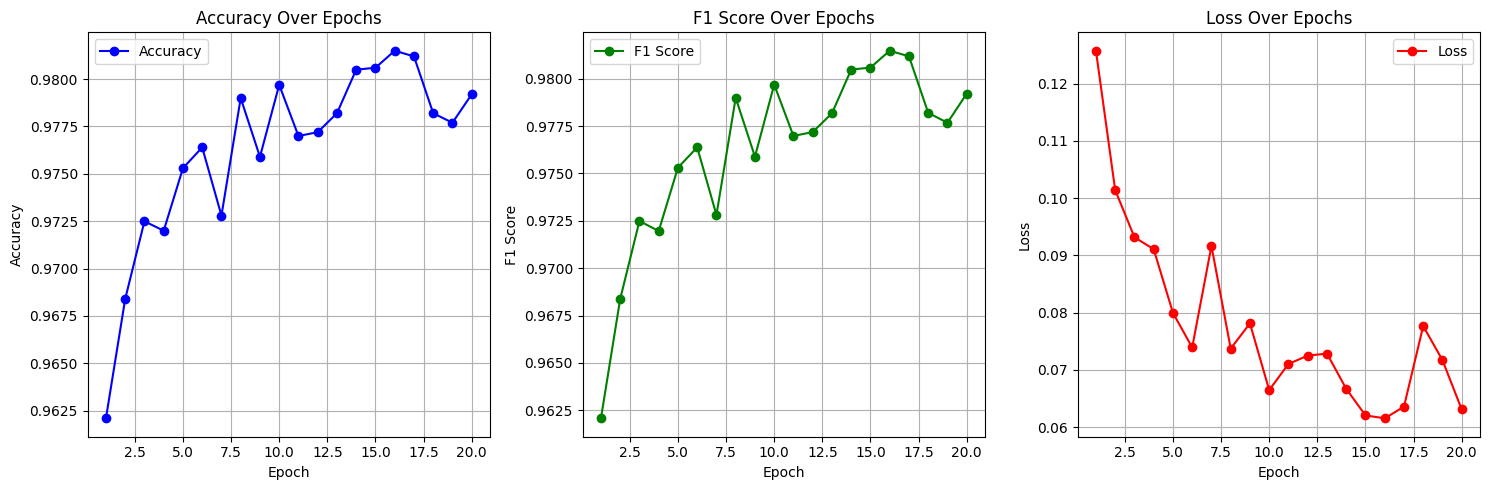

In [8]:
def train_and_evaluate(model, train_loader, eval_loader, criterion, optimizer, epochs=10):
    best_loss = float('inf')
    best_model = None
    best_metrics = None
    best_epoch = None

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        num_batches = len(train_loader)

        # Progress bar with tqdm
        with tqdm(total=num_batches, desc=f"Epoch {epoch+1}/{epochs}") as pbar:
            for i, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                pbar.set_postfix({'Train Loss': running_loss / (i+1)})
                pbar.update(1)

        # Evaluate on validation set after each epoch
        eval_loss, eval_acc, eval_f1, eval_precision, eval_recall = evaluate_model(model, eval_loader, criterion)

        # Store the results for plotting after all epochs
        epoch_accuracies.append(eval_acc)
        epoch_f1_scores.append(eval_f1)
        epoch_losses.append(eval_loss)
        epoch_steps.append(epoch + 1)

        print(f"\nEpoch {epoch+1}: Validation Loss: {eval_loss:.4f}, Accuracy: {eval_acc:.4f}, Precision: {eval_precision:.4f}, Recall: {eval_recall:.4f}, F1 Score: {eval_f1:.4f}")

        # Save the model with the best evaluation loss
        if eval_loss < best_loss:
            best_loss = eval_loss
            best_model = model.state_dict()  # Save the best model
            best_metrics = {
                'Accuracy': eval_acc,
                'Precision': eval_precision,
                'Recall': eval_recall,
                'F1 Score': eval_f1
            }
            best_epoch = epoch + 1

        print(f"Epoch {epoch+1} completed. Average Train Loss: {running_loss / num_batches:.4f}")

    # Save the best model to a file
    torch.save(best_model, 'best_model.pth')
    print(f"Best model saved as 'best_model.pth' at epoch {best_epoch}.")
    print(f"Best metrics at epoch {best_epoch}: {best_metrics}")

    # Plot the metrics after all epochs are processed
    plot_metrics(epoch_steps, epoch_accuracies, epoch_f1_scores, epoch_losses)

# Lists to store metrics
epoch_accuracies = []
epoch_f1_scores = []
epoch_losses = []
epoch_steps = []

# Example function call with both train_loader and eval_loader
train_and_evaluate(model, train_loader, eval_loader, criterion, optimizer, epochs=20)

Epoch 1/20: 100%|██████████| 1875/1875 [00:15<00:00, 119.12it/s, Train Loss=0.416]


              precision    recall  f1-score   support

           0       0.99      0.98      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.96      0.96      1032
           3       0.95      0.95      0.95      1010
           4       0.96      0.95      0.96       982
           5       0.93      0.97      0.95       892
           6       0.98      0.96      0.97       958
           7       0.95      0.96      0.96      1027
           8       0.97      0.94      0.95       974
           9       0.94      0.95      0.95      1009

    accuracy                           0.96      9999
   macro avg       0.96      0.96      0.96      9999
weighted avg       0.96      0.96      0.96      9999


Epoch 1: Validation Loss: 0.1222, Accuracy: 0.9614, F1 Score: 0.9614
Epoch 1 completed. Average Train Loss: 0.4159


Epoch 2/20: 100%|██████████| 1875/1875 [00:16<00:00, 115.24it/s, Train Loss=0.219]


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.95      0.98      0.96      1010
           4       0.97      0.96      0.97       982
           5       0.99      0.94      0.97       892
           6       0.97      0.98      0.98       958
           7       0.96      0.97      0.97      1027
           8       0.97      0.97      0.97       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999


Epoch 2: Validation Loss: 0.0931, Accuracy: 0.9718, F1 Score: 0.9718
Epoch 2 completed. Average Train Loss: 0.2187


Epoch 3/20: 100%|██████████| 1875/1875 [00:15<00:00, 117.22it/s, Train Loss=0.181]


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.97      0.98      1032
           3       0.97      0.98      0.97      1010
           4       0.96      0.98      0.97       982
           5       0.97      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.96      0.97      1027
           8       0.96      0.98      0.97       974
           9       0.97      0.96      0.96      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 3: Validation Loss: 0.0804, Accuracy: 0.9754, F1 Score: 0.9754
Epoch 3 completed. Average Train Loss: 0.1814


Epoch 4/20: 100%|██████████| 1875/1875 [00:15<00:00, 118.60it/s, Train Loss=0.156]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.97      1027
           8       0.96      0.98      0.97       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 4: Validation Loss: 0.0669, Accuracy: 0.9797, F1 Score: 0.9797
Epoch 4 completed. Average Train Loss: 0.1560


Epoch 5/20: 100%|██████████| 1875/1875 [00:16<00:00, 115.22it/s, Train Loss=0.142]


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.99      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 5: Validation Loss: 0.0642, Accuracy: 0.9809, F1 Score: 0.9809
Epoch 5 completed. Average Train Loss: 0.1417


Epoch 6/20: 100%|██████████| 1875/1875 [00:18<00:00, 101.17it/s, Train Loss=0.127]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.99      0.97      0.98       892
           6       0.99      0.97      0.98       958
           7       0.97      0.98      0.97      1027
           8       0.98      0.98      0.98       974
           9       0.97      0.98      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 6: Validation Loss: 0.0646, Accuracy: 0.9808, F1 Score: 0.9808
Epoch 6 completed. Average Train Loss: 0.1266


Epoch 7/20: 100%|██████████| 1875/1875 [00:16<00:00, 110.53it/s, Train Loss=0.116]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.99      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.97      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 7: Validation Loss: 0.0604, Accuracy: 0.9820, F1 Score: 0.9820
Epoch 7 completed. Average Train Loss: 0.1163


Epoch 8/20: 100%|██████████| 1875/1875 [00:16<00:00, 115.47it/s, Train Loss=0.105]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.97      0.99      0.98      1027
           8       0.99      0.98      0.98       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 8: Validation Loss: 0.0578, Accuracy: 0.9840, F1 Score: 0.9840
Epoch 8 completed. Average Train Loss: 0.1049


Epoch 9/20: 100%|██████████| 1875/1875 [00:16<00:00, 116.82it/s, Train Loss=0.0989]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.97      0.99      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.99      0.96      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 9: Validation Loss: 0.0556, Accuracy: 0.9839, F1 Score: 0.9839
Epoch 9 completed. Average Train Loss: 0.0989


Epoch 10/20: 100%|██████████| 1875/1875 [00:15<00:00, 117.60it/s, Train Loss=0.0952]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.99      0.98      1027
           8       0.99      0.98      0.98       974
           9       0.97      0.98      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 10: Validation Loss: 0.0575, Accuracy: 0.9830, F1 Score: 0.9830
Epoch 10 completed. Average Train Loss: 0.0952


Epoch 11/20: 100%|██████████| 1875/1875 [00:15<00:00, 117.44it/s, Train Loss=0.0887]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.99      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.99      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.97      0.98      1027
           8       0.99      0.99      0.99       974
           9       0.97      0.98      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 11: Validation Loss: 0.0574, Accuracy: 0.9836, F1 Score: 0.9836
Epoch 11 completed. Average Train Loss: 0.0887


Epoch 12/20: 100%|██████████| 1875/1875 [00:16<00:00, 115.28it/s, Train Loss=0.083]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.96      0.99      0.97      1010
           4       0.99      0.97      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.97      0.98      1027
           8       0.99      0.98      0.98       974
           9       0.97      0.98      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 12: Validation Loss: 0.0590, Accuracy: 0.9824, F1 Score: 0.9824
Epoch 12 completed. Average Train Loss: 0.0830


Epoch 13/20: 100%|██████████| 1875/1875 [00:16<00:00, 115.29it/s, Train Loss=0.0784]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.99       892
           6       0.99      0.98      0.98       958
           7       0.98      0.98      0.98      1027
           8       0.99      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 13: Validation Loss: 0.0528, Accuracy: 0.9847, F1 Score: 0.9847
Epoch 13 completed. Average Train Loss: 0.0784


Epoch 14/20: 100%|██████████| 1875/1875 [00:16<00:00, 115.39it/s, Train Loss=0.075]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.97      0.99      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.97      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 14: Validation Loss: 0.0614, Accuracy: 0.9832, F1 Score: 0.9832
Epoch 14 completed. Average Train Loss: 0.0750


Epoch 15/20: 100%|██████████| 1875/1875 [00:17<00:00, 110.20it/s, Train Loss=0.0706]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.98      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 15: Validation Loss: 0.0537, Accuracy: 0.9842, F1 Score: 0.9842
Epoch 15 completed. Average Train Loss: 0.0706


Epoch 16/20: 100%|██████████| 1875/1875 [00:16<00:00, 110.33it/s, Train Loss=0.0715]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.99      0.98       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.98      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 16: Validation Loss: 0.0500, Accuracy: 0.9849, F1 Score: 0.9849
Epoch 16 completed. Average Train Loss: 0.0715


Epoch 17/20: 100%|██████████| 1875/1875 [00:16<00:00, 112.58it/s, Train Loss=0.0644]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.98      0.99      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.99       892
           6       0.99      0.98      0.99       958
           7       0.98      0.98      0.98      1027
           8       0.99      0.98      0.99       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99      9999
   macro avg       0.99      0.98      0.99      9999
weighted avg       0.99      0.99      0.99      9999


Epoch 17: Validation Loss: 0.0510, Accuracy: 0.9851, F1 Score: 0.9851
Epoch 17 completed. Average Train Loss: 0.0644


Epoch 18/20: 100%|██████████| 1875/1875 [00:16<00:00, 113.98it/s, Train Loss=0.0632]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.98      0.99       892
           6       0.99      0.98      0.99       958
           7       0.97      0.98      0.98      1027
           8       0.98      0.99      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99      9999
   macro avg       0.99      0.99      0.99      9999
weighted avg       0.99      0.99      0.99      9999


Epoch 18: Validation Loss: 0.0492, Accuracy: 0.9857, F1 Score: 0.9857
Epoch 18 completed. Average Train Loss: 0.0632


Epoch 19/20: 100%|██████████| 1875/1875 [00:16<00:00, 114.80it/s, Train Loss=0.0621]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.97      0.98      1027
           8       0.98      0.99      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.99      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 19: Validation Loss: 0.0502, Accuracy: 0.9850, F1 Score: 0.9850
Epoch 19 completed. Average Train Loss: 0.0621


Epoch 20/20: 100%|██████████| 1875/1875 [00:16<00:00, 115.04it/s, Train Loss=0.0595]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.99      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.97      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 20: Validation Loss: 0.0482, Accuracy: 0.9848, F1 Score: 0.9848
Epoch 20 completed. Average Train Loss: 0.0595


Epoch 1/20: 100%|██████████| 1875/1875 [00:16<00:00, 114.75it/s, Train Loss=0.412]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.96      0.97      0.97       982
           5       0.95      0.97      0.96       892
           6       0.98      0.97      0.97       958
           7       0.98      0.94      0.96      1027
           8       0.96      0.97      0.96       974
           9       0.97      0.93      0.95      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999


Epoch 1: Validation Loss: 0.1148, Accuracy: 0.9658, F1 Score: 0.9657
Epoch 1 completed. Average Train Loss: 0.4116


Epoch 2/20: 100%|██████████| 1875/1875 [00:16<00:00, 113.37it/s, Train Loss=0.221]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1027
           8       0.97      0.97      0.97       974
           9       0.97      0.96      0.96      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999


Epoch 2: Validation Loss: 0.0919, Accuracy: 0.9731, F1 Score: 0.9731
Epoch 2 completed. Average Train Loss: 0.2211


Epoch 3/20: 100%|██████████| 1875/1875 [00:16<00:00, 116.24it/s, Train Loss=0.183]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.99      0.97      1032
           3       0.98      0.97      0.97      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.97      0.98       892
           6       0.99      0.97      0.98       958
           7       0.98      0.96      0.97      1027
           8       0.96      0.98      0.97       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 3: Validation Loss: 0.0818, Accuracy: 0.9758, F1 Score: 0.9758
Epoch 3 completed. Average Train Loss: 0.1827


Epoch 4/20: 100%|██████████| 1875/1875 [00:15<00:00, 118.82it/s, Train Loss=0.16]


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      1.00      0.99      1135
           2       0.99      0.97      0.98      1032
           3       0.99      0.96      0.97      1010
           4       0.98      0.97      0.98       982
           5       0.97      0.98      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.98      0.97      1027
           8       0.97      0.98      0.98       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 4: Validation Loss: 0.0722, Accuracy: 0.9779, F1 Score: 0.9779
Epoch 4 completed. Average Train Loss: 0.1599


Epoch 5/20: 100%|██████████| 1875/1875 [00:17<00:00, 107.79it/s, Train Loss=0.142]


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.99      0.98       958
           7       0.98      0.97      0.97      1027
           8       0.98      0.98      0.98       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 5: Validation Loss: 0.0668, Accuracy: 0.9802, F1 Score: 0.9802
Epoch 5 completed. Average Train Loss: 0.1423


Epoch 6/20: 100%|██████████| 1875/1875 [00:16<00:00, 114.51it/s, Train Loss=0.129]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.97      0.98       892
           6       0.98      0.99      0.98       958
           7       0.98      0.97      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 6: Validation Loss: 0.0663, Accuracy: 0.9806, F1 Score: 0.9806
Epoch 6 completed. Average Train Loss: 0.1292


Epoch 7/20: 100%|██████████| 1875/1875 [00:16<00:00, 116.42it/s, Train Loss=0.117]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.98      0.99       982
           5       0.99      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.97      0.98      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 7: Validation Loss: 0.0546, Accuracy: 0.9835, F1 Score: 0.9835
Epoch 7 completed. Average Train Loss: 0.1168


Epoch 8/20: 100%|██████████| 1875/1875 [00:16<00:00, 116.38it/s, Train Loss=0.112]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.99      0.98      0.98       892
           6       0.98      0.99      0.98       958
           7       0.98      0.98      0.98      1027
           8       0.98      0.99      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 8: Validation Loss: 0.0565, Accuracy: 0.9832, F1 Score: 0.9832
Epoch 8 completed. Average Train Loss: 0.1121


Epoch 9/20: 100%|██████████| 1875/1875 [00:16<00:00, 115.78it/s, Train Loss=0.105]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.99      1032
           3       0.99      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1027
           8       0.97      0.98      0.98       974
           9       0.97      0.98      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 9: Validation Loss: 0.0582, Accuracy: 0.9819, F1 Score: 0.9819
Epoch 9 completed. Average Train Loss: 0.1045


Epoch 10/20: 100%|██████████| 1875/1875 [00:16<00:00, 116.33it/s, Train Loss=0.0934]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.98      0.98      1010
           4       0.97      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.98      0.99      0.98       958
           7       0.97      0.99      0.98      1027
           8       0.99      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 10: Validation Loss: 0.0578, Accuracy: 0.9837, F1 Score: 0.9837
Epoch 10 completed. Average Train Loss: 0.0934


Epoch 11/20: 100%|██████████| 1875/1875 [00:16<00:00, 116.90it/s, Train Loss=0.0912]


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.98      0.98       982
           5       1.00      0.98      0.99       892
           6       0.98      0.99      0.99       958
           7       0.98      0.98      0.98      1027
           8       0.99      0.98      0.99       974
           9       0.97      0.98      0.98      1009

    accuracy                           0.99      9999
   macro avg       0.99      0.99      0.99      9999
weighted avg       0.99      0.99      0.99      9999


Epoch 11: Validation Loss: 0.0495, Accuracy: 0.9853, F1 Score: 0.9853
Epoch 11 completed. Average Train Loss: 0.0912


Epoch 12/20: 100%|██████████| 1875/1875 [00:15<00:00, 118.31it/s, Train Loss=0.0838]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.99      0.98       958
           7       0.98      0.97      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.97      0.98      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 12: Validation Loss: 0.0558, Accuracy: 0.9828, F1 Score: 0.9828
Epoch 12 completed. Average Train Loss: 0.0838


Epoch 13/20: 100%|██████████| 1875/1875 [00:16<00:00, 114.68it/s, Train Loss=0.0845]


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.98      0.99       982
           5       0.99      0.97      0.98       892
           6       0.99      0.99      0.99       958
           7       0.97      0.99      0.98      1027
           8       0.98      0.99      0.99       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.99      0.98      0.98      9999
weighted avg       0.99      0.98      0.98      9999


Epoch 13: Validation Loss: 0.0486, Accuracy: 0.9850, F1 Score: 0.9850
Epoch 13 completed. Average Train Loss: 0.0845


Epoch 14/20: 100%|██████████| 1875/1875 [00:17<00:00, 108.86it/s, Train Loss=0.0778]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.98      0.99      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1027
           8       0.99      0.98      0.98       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99      9999
   macro avg       0.99      0.99      0.99      9999
weighted avg       0.99      0.99      0.99      9999


Epoch 14: Validation Loss: 0.0497, Accuracy: 0.9851, F1 Score: 0.9851
Epoch 14 completed. Average Train Loss: 0.0778


Epoch 15/20: 100%|██████████| 1875/1875 [00:16<00:00, 110.54it/s, Train Loss=0.079]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.98      0.99      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.98      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 15: Validation Loss: 0.0545, Accuracy: 0.9831, F1 Score: 0.9831
Epoch 15 completed. Average Train Loss: 0.0790


Epoch 16/20: 100%|██████████| 1875/1875 [00:16<00:00, 113.23it/s, Train Loss=0.0717]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1027
           8       0.98      0.99      0.98       974
           9       0.97      0.99      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.99      0.98      0.98      9999
weighted avg       0.99      0.98      0.98      9999


Epoch 16: Validation Loss: 0.0506, Accuracy: 0.9850, F1 Score: 0.9850
Epoch 16 completed. Average Train Loss: 0.0717


Epoch 17/20: 100%|██████████| 1875/1875 [00:16<00:00, 115.16it/s, Train Loss=0.0723]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.98      1027
           8       0.99      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99      9999
   macro avg       0.99      0.99      0.99      9999
weighted avg       0.99      0.99      0.99      9999


Epoch 17: Validation Loss: 0.0470, Accuracy: 0.9856, F1 Score: 0.9856
Epoch 17 completed. Average Train Loss: 0.0723


Epoch 18/20: 100%|██████████| 1875/1875 [00:16<00:00, 116.57it/s, Train Loss=0.0694]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.98      0.99       982
           5       1.00      0.98      0.99       892
           6       0.98      0.99      0.99       958
           7       0.98      0.98      0.98      1027
           8       0.99      0.98      0.99       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99      9999
   macro avg       0.99      0.99      0.99      9999
weighted avg       0.99      0.99      0.99      9999


Epoch 18: Validation Loss: 0.0486, Accuracy: 0.9865, F1 Score: 0.9865
Epoch 18 completed. Average Train Loss: 0.0694


Epoch 19/20: 100%|██████████| 1875/1875 [00:16<00:00, 114.73it/s, Train Loss=0.0653]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1027
           8       0.99      0.98      0.99       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.99      9999
   macro avg       0.99      0.99      0.99      9999
weighted avg       0.99      0.99      0.99      9999


Epoch 19: Validation Loss: 0.0512, Accuracy: 0.9852, F1 Score: 0.9852
Epoch 19 completed. Average Train Loss: 0.0653


Epoch 20/20: 100%|██████████| 1875/1875 [00:16<00:00, 112.62it/s, Train Loss=0.0643]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.98      0.99      0.98       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.97      0.98      1027
           8       0.99      0.99      0.99       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99      9999
   macro avg       0.99      0.99      0.99      9999
weighted avg       0.99      0.99      0.99      9999


Epoch 20: Validation Loss: 0.0469, Accuracy: 0.9862, F1 Score: 0.9862
Epoch 20 completed. Average Train Loss: 0.0643


Epoch 1/20: 100%|██████████| 1875/1875 [00:15<00:00, 118.93it/s, Train Loss=0.718]


              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.96      0.94      0.95      1032
           3       0.91      0.96      0.93      1010
           4       0.94      0.94      0.94       982
           5       0.96      0.90      0.93       892
           6       0.94      0.97      0.95       958
           7       0.96      0.93      0.94      1027
           8       0.95      0.93      0.94       974
           9       0.93      0.93      0.93      1009

    accuracy                           0.95      9999
   macro avg       0.95      0.95      0.95      9999
weighted avg       0.95      0.95      0.95      9999


Epoch 1: Validation Loss: 0.1800, Accuracy: 0.9476, F1 Score: 0.9475
Epoch 1 completed. Average Train Loss: 0.7182


Epoch 2/20: 100%|██████████| 1875/1875 [00:15<00:00, 120.61it/s, Train Loss=0.343]


              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.96      0.97      1032
           3       0.96      0.97      0.96      1010
           4       0.96      0.96      0.96       982
           5       0.97      0.94      0.95       892
           6       0.95      0.98      0.96       958
           7       0.95      0.96      0.96      1027
           8       0.97      0.96      0.96       974
           9       0.95      0.94      0.95      1009

    accuracy                           0.96      9999
   macro avg       0.96      0.96      0.96      9999
weighted avg       0.96      0.96      0.96      9999


Epoch 2: Validation Loss: 0.1235, Accuracy: 0.9635, F1 Score: 0.9635
Epoch 2 completed. Average Train Loss: 0.3434


Epoch 3/20: 100%|██████████| 1875/1875 [00:15<00:00, 120.39it/s, Train Loss=0.275]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.98      0.96      0.97      1010
           4       0.96      0.97      0.97       982
           5       0.97      0.96      0.97       892
           6       0.96      0.98      0.97       958
           7       0.97      0.95      0.96      1027
           8       0.95      0.97      0.96       974
           9       0.97      0.94      0.96      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999


Epoch 3: Validation Loss: 0.1011, Accuracy: 0.9695, F1 Score: 0.9695
Epoch 3 completed. Average Train Loss: 0.2749


Epoch 4/20: 100%|██████████| 1875/1875 [00:16<00:00, 114.99it/s, Train Loss=0.237]


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.98      0.97       982
           5       0.98      0.96      0.97       892
           6       0.97      0.98      0.98       958
           7       0.96      0.97      0.97      1027
           8       0.96      0.97      0.96       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999


Epoch 4: Validation Loss: 0.0891, Accuracy: 0.9732, F1 Score: 0.9732
Epoch 4 completed. Average Train Loss: 0.2367


Epoch 5/20: 100%|██████████| 1875/1875 [00:16<00:00, 116.77it/s, Train Loss=0.21]


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.98      0.97      1010
           4       0.98      0.97      0.97       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.97      0.96      0.97      1027
           8       0.98      0.98      0.98       974
           9       0.97      0.96      0.96      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 5: Validation Loss: 0.0775, Accuracy: 0.9767, F1 Score: 0.9767
Epoch 5 completed. Average Train Loss: 0.2097


Epoch 6/20: 100%|██████████| 1875/1875 [00:15<00:00, 117.35it/s, Train Loss=0.189]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1027
           8       0.97      0.98      0.97       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 6: Validation Loss: 0.0723, Accuracy: 0.9787, F1 Score: 0.9787
Epoch 6 completed. Average Train Loss: 0.1885


Epoch 7/20: 100%|██████████| 1875/1875 [00:16<00:00, 114.60it/s, Train Loss=0.174]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.97      0.99      0.98       982
           5       0.99      0.96      0.97       892
           6       0.97      0.98      0.98       958
           7       0.98      0.96      0.97      1027
           8       0.97      0.98      0.98       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 7: Validation Loss: 0.0722, Accuracy: 0.9780, F1 Score: 0.9780
Epoch 7 completed. Average Train Loss: 0.1737


Epoch 8/20: 100%|██████████| 1875/1875 [00:15<00:00, 118.95it/s, Train Loss=0.165]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.97      0.98      0.98      1027
           8       0.97      0.98      0.97       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 8: Validation Loss: 0.0668, Accuracy: 0.9806, F1 Score: 0.9806
Epoch 8 completed. Average Train Loss: 0.1646


Epoch 9/20: 100%|██████████| 1875/1875 [00:15<00:00, 120.17it/s, Train Loss=0.155]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.99      0.97      0.98       958
           7       0.96      0.98      0.97      1027
           8       0.98      0.98      0.98       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 9: Validation Loss: 0.0663, Accuracy: 0.9802, F1 Score: 0.9802
Epoch 9 completed. Average Train Loss: 0.1545


Epoch 10/20: 100%|██████████| 1875/1875 [00:16<00:00, 116.68it/s, Train Loss=0.143]


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.99      0.98       958
           7       0.98      0.97      0.97      1027
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 10: Validation Loss: 0.0652, Accuracy: 0.9800, F1 Score: 0.9800
Epoch 10 completed. Average Train Loss: 0.1435


Epoch 11/20: 100%|██████████| 1875/1875 [00:16<00:00, 116.80it/s, Train Loss=0.138]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.97      0.99      0.98       958
           7       0.98      0.97      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 11: Validation Loss: 0.0596, Accuracy: 0.9819, F1 Score: 0.9819
Epoch 11 completed. Average Train Loss: 0.1380


Epoch 12/20: 100%|██████████| 1875/1875 [00:15<00:00, 121.06it/s, Train Loss=0.132]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.97      0.97      1027
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 12: Validation Loss: 0.0601, Accuracy: 0.9821, F1 Score: 0.9821
Epoch 12 completed. Average Train Loss: 0.1322


Epoch 13/20: 100%|██████████| 1875/1875 [00:17<00:00, 108.15it/s, Train Loss=0.124]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.97      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 13: Validation Loss: 0.0561, Accuracy: 0.9832, F1 Score: 0.9832
Epoch 13 completed. Average Train Loss: 0.1236


Epoch 14/20: 100%|██████████| 1875/1875 [00:16<00:00, 110.95it/s, Train Loss=0.118]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.99      1032
           3       0.99      0.98      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.98      0.99      0.98       958
           7       0.97      0.98      0.97      1027
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 14: Validation Loss: 0.0553, Accuracy: 0.9828, F1 Score: 0.9828
Epoch 14 completed. Average Train Loss: 0.1185


Epoch 15/20: 100%|██████████| 1875/1875 [00:15<00:00, 120.47it/s, Train Loss=0.119]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.97      0.98      0.98      1027
           8       0.98      0.99      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 15: Validation Loss: 0.0550, Accuracy: 0.9837, F1 Score: 0.9837
Epoch 15 completed. Average Train Loss: 0.1188


Epoch 16/20: 100%|██████████| 1875/1875 [00:15<00:00, 120.80it/s, Train Loss=0.113]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 16: Validation Loss: 0.0534, Accuracy: 0.9836, F1 Score: 0.9836
Epoch 16 completed. Average Train Loss: 0.1127


Epoch 17/20: 100%|██████████| 1875/1875 [00:15<00:00, 120.23it/s, Train Loss=0.109]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.98       958
           7       0.98      0.97      0.98      1027
           8       0.98      0.99      0.98       974
           9       0.97      0.98      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 17: Validation Loss: 0.0531, Accuracy: 0.9833, F1 Score: 0.9833
Epoch 17 completed. Average Train Loss: 0.1095


Epoch 18/20: 100%|██████████| 1875/1875 [00:15<00:00, 119.88it/s, Train Loss=0.106]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.98      0.99       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 18: Validation Loss: 0.0513, Accuracy: 0.9847, F1 Score: 0.9847
Epoch 18 completed. Average Train Loss: 0.1061


Epoch 19/20: 100%|██████████| 1875/1875 [00:15<00:00, 118.78it/s, Train Loss=0.102]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.98      0.98      0.98      1027
           8       0.98      0.99      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99      9999
   macro avg       0.99      0.99      0.99      9999
weighted avg       0.99      0.99      0.99      9999


Epoch 19: Validation Loss: 0.0478, Accuracy: 0.9855, F1 Score: 0.9855
Epoch 19 completed. Average Train Loss: 0.1019


Epoch 20/20: 100%|██████████| 1875/1875 [00:15<00:00, 117.48it/s, Train Loss=0.1]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      0.98      0.99      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.99      0.99       892
           6       0.98      0.99      0.99       958
           7       0.98      0.97      0.98      1027
           8       0.99      0.97      0.98       974
           9       0.97      0.98      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 20: Validation Loss: 0.0530, Accuracy: 0.9843, F1 Score: 0.9843
Epoch 20 completed. Average Train Loss: 0.1002


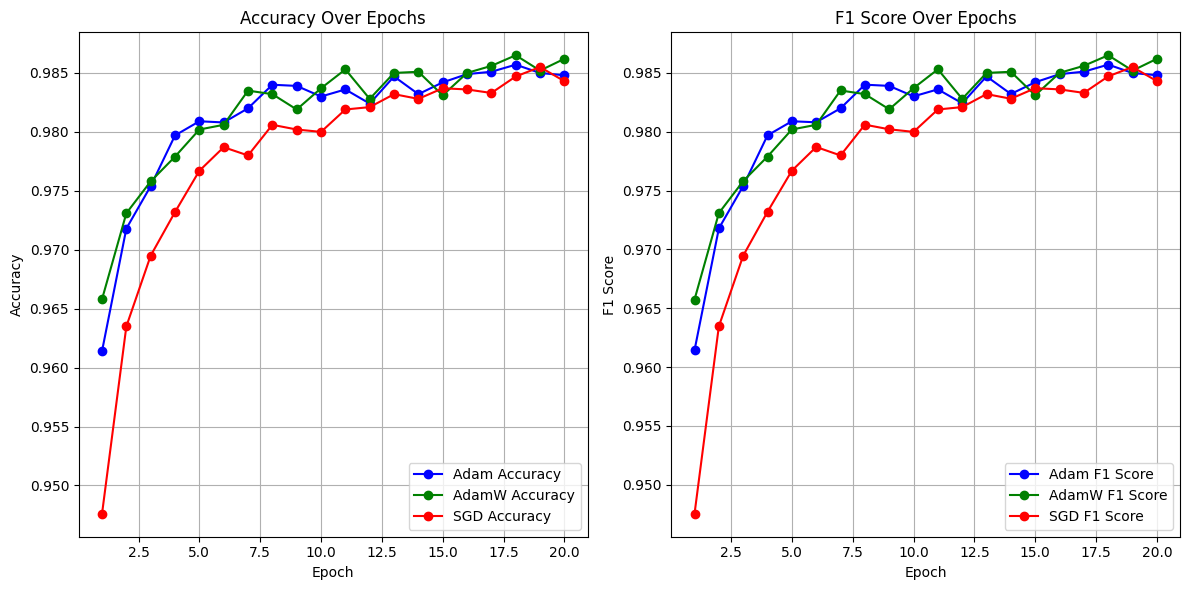

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Define a function to get the optimizer based on its name
def get_optimizer(optimizer_name, model, learning_rate=0.001):
    if optimizer_name == 'Adam':
        return optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'AdamW':
        return optim.AdamW(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD':
        return optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

# Function to train and evaluate with a given optimizer
def train_and_evaluate(model, train_loader, eval_loader, criterion, optimizer, epochs=10):
    best_loss = float('inf')
    best_model = None
    best_metrics = None
    best_epoch = None

    epoch_accuracies = []
    epoch_f1_scores = []
    epoch_steps = []

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        num_batches = len(train_loader)

        # Progress bar with tqdm
        with tqdm(total=num_batches, desc=f"Epoch {epoch+1}/{epochs}") as pbar:
            for i, (inputs, labels) in enumerate(train_loader):
                # Move inputs and labels to the device (GPU or CPU)
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                pbar.set_postfix({'Train Loss': running_loss / (i+1)})
                pbar.update(1)

        # Evaluate on validation set after each epoch
        eval_loss, eval_acc, eval_f1 = evaluate_model(model, eval_loader, criterion)

        # Store the results for plotting after all epochs
        epoch_accuracies.append(eval_acc)
        epoch_f1_scores.append(eval_f1)
        epoch_steps.append(epoch + 1)

        print(f"\nEpoch {epoch+1}: Validation Loss: {eval_loss:.4f}, Accuracy: {eval_acc:.4f}, F1 Score: {eval_f1:.4f}")

        # Save the model with the best evaluation loss
        if eval_loss < best_loss:
            best_loss = eval_loss
            best_model = model.state_dict()  # Save the best model
            best_metrics = {'Accuracy': eval_acc, 'F1 Score': eval_f1}
            best_epoch = epoch + 1

        print(f"Epoch {epoch+1} completed. Average Train Loss: {running_loss / num_batches:.4f}")

    return epoch_steps, epoch_accuracies, epoch_f1_scores

# Function to compare three optimizers and plot the results
def compare_optimizers_and_plot(model, train_loader, eval_loader, criterion, epochs=20):
    optimizers = ['Adam', 'AdamW', 'SGD']
    optimizer_colors = ['blue', 'green', 'red']

    # Create lists to store results for each optimizer
    all_accuracies = {}
    all_f1_scores = {}

    for optimizer_name, color in zip(optimizers, optimizer_colors):
        # Reset the model before each optimizer is tested
        model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        optimizer = get_optimizer(optimizer_name, model)

        # Train and evaluate with the optimizer
        epoch_steps, accuracies, f1_scores = train_and_evaluate(model, train_loader, eval_loader, criterion, optimizer, epochs)

        # Store results for each optimizer
        all_accuracies[optimizer_name] = accuracies
        all_f1_scores[optimizer_name] = f1_scores

    # Plot the results
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot accuracy
    for optimizer_name, color in zip(optimizers, optimizer_colors):
        ax[0].plot(epoch_steps, all_accuracies[optimizer_name], label=f'{optimizer_name} Accuracy', color=color, marker='o')

    # Plot F1 score
    for optimizer_name, color in zip(optimizers, optimizer_colors):
        ax[1].plot(epoch_steps, all_f1_scores[optimizer_name], label=f'{optimizer_name} F1 Score', color=color, marker='o')

    # Customize the accuracy plot
    ax[0].set_title('Accuracy Over Epochs')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[0].grid(True)

    # Customize the F1 score plot
    ax[1].set_title('F1 Score Over Epochs')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('F1 Score')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

# Example call to compare optimizers and plot results
compare_optimizers_and_plot(model, train_loader, eval_loader, criterion, epochs=20)

Epoch 1/10 (Dropout 0.1): 100%|██████████| 1875/1875 [00:48<00:00, 38.85it/s, Train Loss=0.257]


              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.95      0.99      0.97      1135
           2       0.98      0.92      0.95      1032
           3       0.98      0.95      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.96      0.96      0.96       892
           6       0.97      0.98      0.97       958
           7       0.93      0.96      0.95      1027
           8       0.98      0.94      0.96       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.96      9999
   macro avg       0.96      0.96      0.96      9999
weighted avg       0.96      0.96      0.96      9999


Epoch 1: Validation Loss: 0.1221, Accuracy: 0.9622, F1 Score: 0.9621
Epoch 1 completed. Average Train Loss: 0.2569


Epoch 2/10 (Dropout 0.1): 100%|██████████| 1875/1875 [00:25<00:00, 72.48it/s, Train Loss=0.15]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.96      0.99      0.97       982
           5       0.98      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.97      0.98      0.97      1027
           8       0.97      0.97      0.97       974
           9       0.98      0.94      0.96      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999


Epoch 2: Validation Loss: 0.0869, Accuracy: 0.9742, F1 Score: 0.9742
Epoch 2 completed. Average Train Loss: 0.1502


Epoch 3/10 (Dropout 0.1): 100%|██████████| 1875/1875 [00:26<00:00, 71.43it/s, Train Loss=0.122]


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.96      0.98      0.97       982
           5       0.98      0.98      0.98       892
           6       0.98      0.97      0.98       958
           7       0.98      0.95      0.97      1027
           8       0.97      0.98      0.98       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 3: Validation Loss: 0.0763, Accuracy: 0.9767, F1 Score: 0.9767
Epoch 3 completed. Average Train Loss: 0.1225


Epoch 4/10 (Dropout 0.1): 100%|██████████| 1875/1875 [00:26<00:00, 71.37it/s, Train Loss=0.106]


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.99      0.98       958
           7       0.98      0.97      0.97      1027
           8       0.99      0.96      0.97       974
           9       0.96      0.98      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 4: Validation Loss: 0.0701, Accuracy: 0.9793, F1 Score: 0.9793
Epoch 4 completed. Average Train Loss: 0.1056


Epoch 5/10 (Dropout 0.1): 100%|██████████| 1875/1875 [00:28<00:00, 66.34it/s, Train Loss=0.0956]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.99      0.98       958
           7       0.98      0.98      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 5: Validation Loss: 0.0650, Accuracy: 0.9812, F1 Score: 0.9812
Epoch 5 completed. Average Train Loss: 0.0956


Epoch 6/10 (Dropout 0.1): 100%|██████████| 1875/1875 [00:26<00:00, 69.94it/s, Train Loss=0.0859]


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.99      0.98       958
           7       0.97      0.98      0.97      1027
           8       0.98      0.97      0.98       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 6: Validation Loss: 0.0733, Accuracy: 0.9786, F1 Score: 0.9786
Epoch 6 completed. Average Train Loss: 0.0859


Epoch 7/10 (Dropout 0.1): 100%|██████████| 1875/1875 [00:26<00:00, 71.73it/s, Train Loss=0.078]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.98      0.97      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.99      0.97      0.98       958
           7       0.98      0.97      0.98      1027
           8       0.93      0.99      0.96       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 7: Validation Loss: 0.0746, Accuracy: 0.9773, F1 Score: 0.9773
Epoch 7 completed. Average Train Loss: 0.0780


Epoch 8/10 (Dropout 0.1): 100%|██████████| 1875/1875 [00:25<00:00, 74.33it/s, Train Loss=0.0724]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.99      0.97      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.98      0.98      1027
           8       0.99      0.97      0.98       974
           9       0.96      0.98      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 8: Validation Loss: 0.0672, Accuracy: 0.9804, F1 Score: 0.9804
Epoch 8 completed. Average Train Loss: 0.0724


Epoch 9/10 (Dropout 0.1): 100%|██████████| 1875/1875 [00:26<00:00, 70.12it/s, Train Loss=0.0673]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.96      0.99      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.99      0.97      0.98       892
           6       0.97      0.99      0.98       958
           7       0.98      0.98      0.98      1027
           8       0.98      0.96      0.97       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 9: Validation Loss: 0.0720, Accuracy: 0.9790, F1 Score: 0.9790
Epoch 9 completed. Average Train Loss: 0.0673


Epoch 10/10 (Dropout 0.1): 100%|██████████| 1875/1875 [00:25<00:00, 74.88it/s, Train Loss=0.0641]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.98      0.97      0.97      1010
           4       0.97      0.99      0.98       982
           5       0.95      0.99      0.97       892
           6       0.99      0.97      0.98       958
           7       0.99      0.98      0.98      1027
           8       0.99      0.97      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 10: Validation Loss: 0.0712, Accuracy: 0.9798, F1 Score: 0.9798
Epoch 10 completed. Average Train Loss: 0.0641


Epoch 1/10 (Dropout 0.2): 100%|██████████| 1875/1875 [00:25<00:00, 72.61it/s, Train Loss=0.273]


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.98      0.95      0.97      1032
           3       0.95      0.97      0.96      1010
           4       0.97      0.96      0.97       982
           5       0.97      0.95      0.96       892
           6       0.96      0.98      0.97       958
           7       0.96      0.96      0.96      1027
           8       0.95      0.97      0.96       974
           9       0.96      0.94      0.95      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999


Epoch 1: Validation Loss: 0.1084, Accuracy: 0.9658, F1 Score: 0.9658
Epoch 1 completed. Average Train Loss: 0.2731


Epoch 2/10 (Dropout 0.2): 100%|██████████| 1875/1875 [00:27<00:00, 69.36it/s, Train Loss=0.172]


              precision    recall  f1-score   support

           0       0.99      0.98      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.97      0.98      0.97       982
           5       0.98      0.95      0.96       892
           6       0.96      0.98      0.97       958
           7       0.96      0.98      0.97      1027
           8       0.97      0.98      0.97       974
           9       0.98      0.95      0.96      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999


Epoch 2: Validation Loss: 0.0935, Accuracy: 0.9723, F1 Score: 0.9723
Epoch 2 completed. Average Train Loss: 0.1724


Epoch 3/10 (Dropout 0.2): 100%|██████████| 1875/1875 [00:26<00:00, 71.93it/s, Train Loss=0.145]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       1.00      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.99      0.98      1010
           4       0.96      0.98      0.97       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.96      0.97      1027
           8       0.98      0.96      0.97       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 3: Validation Loss: 0.0842, Accuracy: 0.9754, F1 Score: 0.9754
Epoch 3 completed. Average Train Loss: 0.1455


Epoch 4/10 (Dropout 0.2): 100%|██████████| 1875/1875 [00:25<00:00, 74.57it/s, Train Loss=0.128]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.98      1.00      0.99      1135
           2       0.99      0.97      0.98      1032
           3       0.98      0.97      0.97      1010
           4       0.98      0.97      0.97       982
           5       0.98      0.98      0.98       892
           6       0.98      0.99      0.98       958
           7       0.97      0.98      0.97      1027
           8       0.97      0.97      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 4: Validation Loss: 0.0734, Accuracy: 0.9783, F1 Score: 0.9783
Epoch 4 completed. Average Train Loss: 0.1277


Epoch 5/10 (Dropout 0.2): 100%|██████████| 1875/1875 [00:25<00:00, 73.25it/s, Train Loss=0.116]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.96      0.98      0.97      1010
           4       0.97      0.98      0.98       982
           5       0.99      0.96      0.98       892
           6       0.97      0.99      0.98       958
           7       0.98      0.97      0.97      1027
           8       0.97      0.97      0.97       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 5: Validation Loss: 0.0738, Accuracy: 0.9768, F1 Score: 0.9768
Epoch 5 completed. Average Train Loss: 0.1162


Epoch 6/10 (Dropout 0.2): 100%|██████████| 1875/1875 [00:24<00:00, 75.59it/s, Train Loss=0.11]


              precision    recall  f1-score   support

           0       0.99      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.99      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.99      0.97      0.98       982
           5       0.96      0.97      0.96       892
           6       0.97      0.99      0.98       958
           7       0.97      0.97      0.97      1027
           8       0.94      0.98      0.96       974
           9       0.99      0.91      0.95      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999


Epoch 6: Validation Loss: 0.0917, Accuracy: 0.9723, F1 Score: 0.9722
Epoch 6 completed. Average Train Loss: 0.1102


Epoch 7/10 (Dropout 0.2): 100%|██████████| 1875/1875 [00:26<00:00, 71.16it/s, Train Loss=0.0995]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.97      0.98      0.98       982
           5       0.97      0.98      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.98      0.98      1027
           8       0.98      0.97      0.97       974
           9       0.99      0.96      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 7: Validation Loss: 0.0668, Accuracy: 0.9796, F1 Score: 0.9796
Epoch 7 completed. Average Train Loss: 0.0995


Epoch 8/10 (Dropout 0.2): 100%|██████████| 1875/1875 [00:27<00:00, 69.21it/s, Train Loss=0.0946]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.97      0.97       892
           6       0.99      0.98      0.98       958
           7       0.98      0.98      0.98      1027
           8       0.97      0.98      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 8: Validation Loss: 0.0619, Accuracy: 0.9812, F1 Score: 0.9812
Epoch 8 completed. Average Train Loss: 0.0946


Epoch 9/10 (Dropout 0.2): 100%|██████████| 1875/1875 [00:26<00:00, 71.09it/s, Train Loss=0.0855]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.99      0.98      0.99       958
           7       0.99      0.97      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 9: Validation Loss: 0.0614, Accuracy: 0.9823, F1 Score: 0.9823
Epoch 9 completed. Average Train Loss: 0.0855


Epoch 10/10 (Dropout 0.2): 100%|██████████| 1875/1875 [00:25<00:00, 74.34it/s, Train Loss=0.0868]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.98      0.97      0.98      1010
           4       0.97      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 10: Validation Loss: 0.0675, Accuracy: 0.9803, F1 Score: 0.9803
Epoch 10 completed. Average Train Loss: 0.0868


Epoch 1/10 (Dropout 0.3): 100%|██████████| 1875/1875 [00:26<00:00, 71.59it/s, Train Loss=0.318]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.95      0.96      0.96      1032
           3       0.98      0.93      0.95      1010
           4       0.95      0.97      0.96       982
           5       0.93      0.97      0.95       892
           6       0.96      0.97      0.97       958
           7       0.95      0.97      0.96      1027
           8       0.95      0.96      0.96       974
           9       0.98      0.91      0.94      1009

    accuracy                           0.96      9999
   macro avg       0.96      0.96      0.96      9999
weighted avg       0.96      0.96      0.96      9999


Epoch 1: Validation Loss: 0.1262, Accuracy: 0.9615, F1 Score: 0.9614
Epoch 1 completed. Average Train Loss: 0.3179


Epoch 2/10 (Dropout 0.3): 100%|██████████| 1875/1875 [00:25<00:00, 73.48it/s, Train Loss=0.204]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.98      0.97      1032
           3       0.97      0.96      0.97      1010
           4       0.95      0.97      0.96       982
           5       0.96      0.97      0.97       892
           6       0.98      0.96      0.97       958
           7       0.98      0.95      0.97      1027
           8       0.98      0.93      0.96       974
           9       0.94      0.96      0.95      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999


Epoch 2: Validation Loss: 0.1011, Accuracy: 0.9672, F1 Score: 0.9672
Epoch 2 completed. Average Train Loss: 0.2044


Epoch 3/10 (Dropout 0.3): 100%|██████████| 1875/1875 [00:27<00:00, 68.60it/s, Train Loss=0.176]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.98      0.97      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.96      0.98      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1027
           8       0.98      0.95      0.97       974
           9       0.96      0.97      0.97      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999


Epoch 3: Validation Loss: 0.0894, Accuracy: 0.9732, F1 Score: 0.9732
Epoch 3 completed. Average Train Loss: 0.1759


Epoch 4/10 (Dropout 0.3): 100%|██████████| 1875/1875 [00:27<00:00, 68.04it/s, Train Loss=0.158]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.98      0.97      1010
           4       0.96      0.98      0.97       982
           5       0.99      0.96      0.97       892
           6       0.99      0.97      0.98       958
           7       0.96      0.98      0.97      1027
           8       0.97      0.97      0.97       974
           9       0.99      0.95      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 4: Validation Loss: 0.0790, Accuracy: 0.9761, F1 Score: 0.9761
Epoch 4 completed. Average Train Loss: 0.1578


Epoch 5/10 (Dropout 0.3): 100%|██████████| 1875/1875 [00:25<00:00, 73.44it/s, Train Loss=0.144]


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.98      0.96      0.97      1010
           4       0.97      0.98      0.98       982
           5       0.95      0.99      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.96      0.97      1027
           8       0.98      0.97      0.98       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 5: Validation Loss: 0.0764, Accuracy: 0.9755, F1 Score: 0.9755
Epoch 5 completed. Average Train Loss: 0.1437


Epoch 6/10 (Dropout 0.3): 100%|██████████| 1875/1875 [00:26<00:00, 69.84it/s, Train Loss=0.134]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.95      0.97       982
           5       0.99      0.96      0.98       892
           6       0.96      0.99      0.97       958
           7       0.98      0.96      0.97      1027
           8       0.97      0.98      0.98       974
           9       0.96      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 6: Validation Loss: 0.0814, Accuracy: 0.9757, F1 Score: 0.9757
Epoch 6 completed. Average Train Loss: 0.1338


Epoch 7/10 (Dropout 0.3): 100%|██████████| 1875/1875 [00:25<00:00, 73.18it/s, Train Loss=0.126]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.97      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.99      0.98       958
           7       0.97      0.98      0.98      1027
           8       0.98      0.97      0.98       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 7: Validation Loss: 0.0656, Accuracy: 0.9803, F1 Score: 0.9803
Epoch 7 completed. Average Train Loss: 0.1264


Epoch 8/10 (Dropout 0.3): 100%|██████████| 1875/1875 [00:26<00:00, 70.25it/s, Train Loss=0.119]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.97      0.99      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.97      0.98       958
           7       0.98      0.98      0.98      1027
           8       0.98      0.97      0.98       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 8: Validation Loss: 0.0693, Accuracy: 0.9786, F1 Score: 0.9786
Epoch 8 completed. Average Train Loss: 0.1194


Epoch 9/10 (Dropout 0.3): 100%|██████████| 1875/1875 [00:25<00:00, 73.68it/s, Train Loss=0.116]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.97      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.97      0.98      0.98       958
           7       0.98      0.98      0.98      1027
           8       0.98      0.97      0.98       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 9: Validation Loss: 0.0658, Accuracy: 0.9798, F1 Score: 0.9798
Epoch 9 completed. Average Train Loss: 0.1158


Epoch 10/10 (Dropout 0.3): 100%|██████████| 1875/1875 [00:28<00:00, 66.20it/s, Train Loss=0.109]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.99      0.97      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.99      0.98       892
           6       0.99      0.97      0.98       958
           7       0.98      0.97      0.97      1027
           8       0.97      0.98      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 10: Validation Loss: 0.0670, Accuracy: 0.9794, F1 Score: 0.9794
Epoch 10 completed. Average Train Loss: 0.1093


Epoch 1/10 (Dropout 0.5): 100%|██████████| 1875/1875 [00:25<00:00, 72.72it/s, Train Loss=0.427]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.97      0.98      0.97      1135
           2       0.97      0.94      0.95      1032
           3       0.96      0.95      0.95      1010
           4       0.93      0.96      0.94       982
           5       0.95      0.95      0.95       892
           6       0.95      0.97      0.96       958
           7       0.97      0.93      0.95      1027
           8       0.95      0.94      0.94       974
           9       0.93      0.95      0.94      1009

    accuracy                           0.95      9999
   macro avg       0.95      0.95      0.95      9999
weighted avg       0.95      0.95      0.95      9999


Epoch 1: Validation Loss: 0.1438, Accuracy: 0.9546, F1 Score: 0.9546
Epoch 1 completed. Average Train Loss: 0.4266


Epoch 2/10 (Dropout 0.5): 100%|██████████| 1875/1875 [00:25<00:00, 73.37it/s, Train Loss=0.296]


              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.95      0.97      0.96      1032
           3       0.95      0.95      0.95      1010
           4       0.97      0.96      0.96       982
           5       0.99      0.91      0.95       892
           6       0.97      0.98      0.97       958
           7       0.96      0.96      0.96      1027
           8       0.95      0.96      0.95       974
           9       0.95      0.96      0.96      1009

    accuracy                           0.96      9999
   macro avg       0.96      0.96      0.96      9999
weighted avg       0.96      0.96      0.96      9999


Epoch 2: Validation Loss: 0.1166, Accuracy: 0.9623, F1 Score: 0.9622
Epoch 2 completed. Average Train Loss: 0.2955


Epoch 3/10 (Dropout 0.5): 100%|██████████| 1875/1875 [00:26<00:00, 70.14it/s, Train Loss=0.264]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.97      0.96      0.97      1032
           3       0.95      0.97      0.96      1010
           4       0.96      0.98      0.97       982
           5       0.97      0.95      0.96       892
           6       0.97      0.98      0.98       958
           7       0.97      0.95      0.96      1027
           8       0.96      0.97      0.96       974
           9       0.97      0.94      0.96      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999


Epoch 3: Validation Loss: 0.1035, Accuracy: 0.9681, F1 Score: 0.9680
Epoch 3 completed. Average Train Loss: 0.2639


Epoch 4/10 (Dropout 0.5): 100%|██████████| 1875/1875 [00:25<00:00, 74.36it/s, Train Loss=0.242]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.98      0.97      1032
           3       0.97      0.96      0.97      1010
           4       0.98      0.95      0.97       982
           5       0.98      0.96      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.96      0.96      1027
           8       0.96      0.97      0.97       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999


Epoch 4: Validation Loss: 0.0972, Accuracy: 0.9704, F1 Score: 0.9704
Epoch 4 completed. Average Train Loss: 0.2416


Epoch 5/10 (Dropout 0.5): 100%|██████████| 1875/1875 [00:26<00:00, 69.67it/s, Train Loss=0.23]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.96      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.96      0.98      0.97       982
           5       0.98      0.95      0.96       892
           6       0.95      0.99      0.97       958
           7       0.97      0.97      0.97      1027
           8       0.96      0.97      0.96       974
           9       0.98      0.94      0.96      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999


Epoch 5: Validation Loss: 0.0943, Accuracy: 0.9709, F1 Score: 0.9709
Epoch 5 completed. Average Train Loss: 0.2300


Epoch 6/10 (Dropout 0.5): 100%|██████████| 1875/1875 [00:27<00:00, 68.73it/s, Train Loss=0.215]


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.96      0.97      1010
           4       0.97      0.98      0.98       982
           5       0.97      0.96      0.97       892
           6       0.97      0.98      0.97       958
           7       0.97      0.96      0.97      1027
           8       0.98      0.96      0.97       974
           9       0.97      0.96      0.96      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999


Epoch 6: Validation Loss: 0.0850, Accuracy: 0.9742, F1 Score: 0.9742
Epoch 6 completed. Average Train Loss: 0.2148


Epoch 7/10 (Dropout 0.5): 100%|██████████| 1875/1875 [00:27<00:00, 68.71it/s, Train Loss=0.205]


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.96      0.98      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.97      0.97       892
           6       0.97      0.98      0.98       958
           7       0.98      0.96      0.97      1027
           8       0.98      0.96      0.97       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999


Epoch 7: Validation Loss: 0.0820, Accuracy: 0.9748, F1 Score: 0.9748
Epoch 7 completed. Average Train Loss: 0.2047


Epoch 8/10 (Dropout 0.5): 100%|██████████| 1875/1875 [00:25<00:00, 73.12it/s, Train Loss=0.2]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      0.96      0.97      1010
           4       0.98      0.96      0.97       982
           5       0.97      0.98      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.97      0.97      1027
           8       0.98      0.96      0.97       974
           9       0.95      0.98      0.96      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999


Epoch 8: Validation Loss: 0.0820, Accuracy: 0.9747, F1 Score: 0.9747
Epoch 8 completed. Average Train Loss: 0.2003


Epoch 9/10 (Dropout 0.5): 100%|██████████| 1875/1875 [00:26<00:00, 69.92it/s, Train Loss=0.185]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.98      0.97      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.96      0.97      1027
           8       0.97      0.96      0.97       974
           9       0.96      0.98      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 9: Validation Loss: 0.0757, Accuracy: 0.9772, F1 Score: 0.9772
Epoch 9 completed. Average Train Loss: 0.1853


Epoch 10/10 (Dropout 0.5): 100%|██████████| 1875/1875 [00:25<00:00, 72.46it/s, Train Loss=0.186]


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1027
           8       0.97      0.97      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 10: Validation Loss: 0.0714, Accuracy: 0.9784, F1 Score: 0.9784
Epoch 10 completed. Average Train Loss: 0.1860


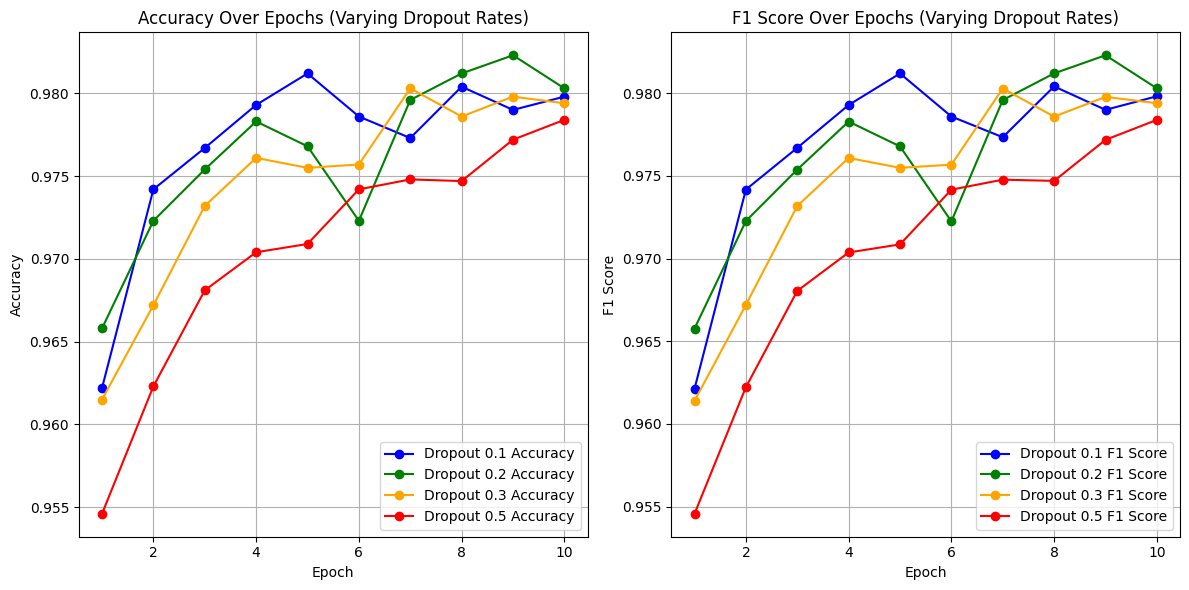

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Function to set the dropout rate in the model during training
def set_dropout_rate(model, dropout_rate):
    for module in model.modules():
        if isinstance(module, torch.nn.Dropout):
            module.p = dropout_rate

# Function to train and evaluate with a given optimizer and dropout rate
def train_and_evaluate_with_dropout(model, train_loader, eval_loader, criterion, optimizer, dropout_rate, epochs=10):
    set_dropout_rate(model, dropout_rate)  # Set the dropout rate for training

    best_loss = float('inf')
    best_model = None
    best_metrics = None
    best_epoch = None

    epoch_accuracies = []
    epoch_f1_scores = []
    epoch_steps = []

    for epoch in range(epochs):
        model.train()  # Set the model to training mode (dropout active)

        running_loss = 0.0
        num_batches = len(train_loader)

        # Progress bar with tqdm
        with tqdm(total=num_batches, desc=f"Epoch {epoch+1}/{epochs} (Dropout {dropout_rate})") as pbar:

            for i, (inputs, labels) in enumerate(train_loader):

                # Move inputs and labels to the device (GPU or CPU)
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                pbar.set_postfix({'Train Loss': running_loss / (i+1)})
                pbar.update(1)

        # After each epoch, evaluate the model
        model.eval()  # Disable dropout for evaluation

        eval_loss, eval_acc, eval_f1 = evaluate_model(model, eval_loader, criterion)

        # Store the results for plotting
        epoch_accuracies.append(eval_acc)
        epoch_f1_scores.append(eval_f1)
        epoch_steps.append(epoch + 1)

        print(f"\nEpoch {epoch+1}: Validation Loss: {eval_loss:.4f}, Accuracy: {eval_acc:.4f}, F1 Score: {eval_f1:.4f}")

        # Save the model with the best evaluation loss
        if eval_loss < best_loss:
            best_loss = eval_loss
            best_model = model.state_dict()  # Save the best model
            best_metrics = {'Accuracy': eval_acc, 'F1 Score': eval_f1}
            best_epoch = epoch + 1

        print(f"Epoch {epoch+1} completed. Average Train Loss: {running_loss / num_batches:.4f}")

    return epoch_steps, epoch_accuracies, epoch_f1_scores

# Function to compare different dropout rates and plot the results
def compare_dropout_rates_and_plot(model_class, train_loader, eval_loader, criterion, input_size, hidden_sizes, output_size, activation_fn, learning_rate=1e-02, epochs=20):

    dropout_rates = [0.1, 0.2, 0.3, 0.5]
    dropout_colors = ['blue', 'green', 'orange', 'red']

    # Create lists to store results for each dropout rate
    all_accuracies = {}
    all_f1_scores = {}

    for dropout_rate, color in zip(dropout_rates, dropout_colors):

        # Reinitialize the model from scratch before each dropout test
        model = model_class(input_size, hidden_sizes, output_size, activation_fn).to(device)  # Pass the required arguments
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Fixed learning rate

        # Train and evaluate with the dropout rate
        epoch_steps, accuracies, f1_scores = train_and_evaluate_with_dropout(model, train_loader, eval_loader, criterion, optimizer, dropout_rate, epochs)

        # Store results for each dropout rate
        all_accuracies[dropout_rate] = accuracies
        all_f1_scores[dropout_rate] = f1_scores

    # Plot the results
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot accuracy
    for dropout_rate, color in zip(dropout_rates, dropout_colors):
        ax[0].plot(epoch_steps, all_accuracies[dropout_rate], label=f'Dropout {dropout_rate} Accuracy', color=color, marker='o')

    # Plot F1 score
    for dropout_rate, color in zip(dropout_rates, dropout_colors):
        ax[1].plot(epoch_steps, all_f1_scores[dropout_rate], label=f'Dropout {dropout_rate} F1 Score', color=color, marker='o')

    # Customize the accuracy plot
    ax[0].set_title('Accuracy Over Epochs (Varying Dropout Rates)')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[0].grid(True)

    # Customize the F1 score plot
    ax[1].set_title('F1 Score Over Epochs (Varying Dropout Rates)')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('F1 Score')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

# Example call to compare dropout rates and plot results
compare_dropout_rates_and_plot(MLP, train_loader, eval_loader, criterion, input_size=784, hidden_sizes=[256, 128], output_size=10, activation_fn=torch.nn.ReLU(), learning_rate=1e-02, epochs=10)


Training model with 1 hidden layers: [256]


Epoch 1/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:29<00:00, 62.60it/s, Train Loss=0.224] 


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.97      0.96      0.96      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.95      0.96       982
           5       0.95      0.98      0.97       892
           6       0.98      0.97      0.98       958
           7       0.97      0.95      0.96      1027
           8       0.97      0.95      0.96       974
           9       0.94      0.97      0.95      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999


Epoch 1: Validation Loss: 0.1063, Accuracy: 0.9673, F1 Score: 0.9673
Epoch 1 completed. Average Train Loss: 0.2235


Epoch 2/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:21<00:00, 85.26it/s, Train Loss=0.107]


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.98      0.98      0.98      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.96      0.97       892
           6       0.99      0.97      0.98       958
           7       0.97      0.96      0.96      1027
           8       0.96      0.97      0.96       974
           9       0.95      0.97      0.96      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999


Epoch 2: Validation Loss: 0.0849, Accuracy: 0.9732, F1 Score: 0.9732
Epoch 2 completed. Average Train Loss: 0.1066


Epoch 3/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:23<00:00, 81.08it/s, Train Loss=0.0787]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.96      0.97       892
           6       0.99      0.98      0.98       958
           7       0.98      0.97      0.98      1027
           8       0.97      0.96      0.97       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 3: Validation Loss: 0.0726, Accuracy: 0.9780, F1 Score: 0.9780
Epoch 3 completed. Average Train Loss: 0.0787


Epoch 4/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:23<00:00, 80.42it/s, Train Loss=0.0624]


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.98      0.97      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.97      0.98       892
           6       0.97      0.99      0.98       958
           7       0.97      0.98      0.98      1027
           8       0.98      0.97      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 4: Validation Loss: 0.0696, Accuracy: 0.9786, F1 Score: 0.9786
Epoch 4 completed. Average Train Loss: 0.0624


Epoch 5/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:22<00:00, 82.08it/s, Train Loss=0.0516]


              precision    recall  f1-score   support

           0       0.99      0.98      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.96      0.98      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.99      0.95      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.98      1027
           8       0.96      0.98      0.97       974
           9       0.96      0.98      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 5: Validation Loss: 0.0753, Accuracy: 0.9760, F1 Score: 0.9760
Epoch 5 completed. Average Train Loss: 0.0516


Epoch 6/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:22<00:00, 82.68it/s, Train Loss=0.0434]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.99      0.97      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.97      0.98      0.98      1027
           8       0.96      0.98      0.97       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 6: Validation Loss: 0.0675, Accuracy: 0.9806, F1 Score: 0.9806
Epoch 6 completed. Average Train Loss: 0.0434


Epoch 7/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:23<00:00, 80.32it/s, Train Loss=0.0393]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.97      0.98      1027
           8       0.98      0.97      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 7: Validation Loss: 0.0618, Accuracy: 0.9825, F1 Score: 0.9825
Epoch 7 completed. Average Train Loss: 0.0393


Epoch 8/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:24<00:00, 77.63it/s, Train Loss=0.0323]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.96      0.99      0.97      1010
           4       0.97      0.98      0.98       982
           5       0.99      0.96      0.98       892
           6       0.99      0.98      0.99       958
           7       0.99      0.97      0.98      1027
           8       0.97      0.98      0.97       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 8: Validation Loss: 0.0698, Accuracy: 0.9793, F1 Score: 0.9793
Epoch 8 completed. Average Train Loss: 0.0323


Epoch 9/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:22<00:00, 84.12it/s, Train Loss=0.0267]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.97      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.97      0.98       958
           7       0.97      0.98      0.98      1027
           8       0.98      0.97      0.97       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 9: Validation Loss: 0.0664, Accuracy: 0.9811, F1 Score: 0.9811
Epoch 9 completed. Average Train Loss: 0.0267


Epoch 10/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:23<00:00, 80.12it/s, Train Loss=0.0265]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.99      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.97      0.98      1027
           8       0.98      0.97      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 10: Validation Loss: 0.0610, Accuracy: 0.9809, F1 Score: 0.9809
Epoch 10 completed. Average Train Loss: 0.0265


Epoch 11/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:23<00:00, 80.24it/s, Train Loss=0.0246]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.96      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.99      0.99       958
           7       0.98      0.98      0.98      1027
           8       0.97      0.98      0.97       974
           9       0.99      0.96      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 11: Validation Loss: 0.0632, Accuracy: 0.9808, F1 Score: 0.9808
Epoch 11 completed. Average Train Loss: 0.0246


Epoch 12/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:22<00:00, 83.99it/s, Train Loss=0.0194]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.99      0.97      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.98      0.98      1027
           8       0.96      0.99      0.97       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 12: Validation Loss: 0.0644, Accuracy: 0.9821, F1 Score: 0.9821
Epoch 12 completed. Average Train Loss: 0.0194


Epoch 13/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:22<00:00, 82.88it/s, Train Loss=0.019]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.97      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.99      0.98      0.98       958
           7       0.99      0.97      0.98      1027
           8       0.97      0.98      0.97       974
           9       0.97      0.98      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 13: Validation Loss: 0.0728, Accuracy: 0.9803, F1 Score: 0.9803
Epoch 13 completed. Average Train Loss: 0.0190


Epoch 14/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:23<00:00, 78.89it/s, Train Loss=0.0184]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.97      0.98       958
           7       0.98      0.97      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 14: Validation Loss: 0.0701, Accuracy: 0.9807, F1 Score: 0.9807
Epoch 14 completed. Average Train Loss: 0.0184


Epoch 15/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:22<00:00, 81.72it/s, Train Loss=0.0169]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.97      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.97      0.98       892
           6       0.98      0.99      0.98       958
           7       0.98      0.97      0.98      1027
           8       0.97      0.97      0.97       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 15: Validation Loss: 0.0730, Accuracy: 0.9795, F1 Score: 0.9795
Epoch 15 completed. Average Train Loss: 0.0169
Training model with 2 hidden layers: [512, 256]


Epoch 1/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:31<00:00, 58.87it/s, Train Loss=0.197]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.97      0.98       982
           5       0.97      0.97      0.97       892
           6       0.99      0.97      0.98       958
           7       0.98      0.97      0.97      1027
           8       0.97      0.97      0.97       974
           9       0.97      0.96      0.96      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 1: Validation Loss: 0.0810, Accuracy: 0.9754, F1 Score: 0.9754
Epoch 1 completed. Average Train Loss: 0.1971


Epoch 2/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:32<00:00, 57.96it/s, Train Loss=0.0977]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.98      0.97      0.97      1010
           4       0.97      0.98      0.98       982
           5       0.98      0.97      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.97      0.98      1027
           8       0.96      0.98      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 2: Validation Loss: 0.0669, Accuracy: 0.9781, F1 Score: 0.9781
Epoch 2 completed. Average Train Loss: 0.0977


Epoch 3/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:32<00:00, 57.82it/s, Train Loss=0.0712]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.97      1.00      0.98      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.98      0.97      1010
           4       0.95      0.99      0.97       982
           5       0.96      0.99      0.97       892
           6       0.99      0.95      0.97       958
           7       0.98      0.95      0.96      1027
           8       0.98      0.96      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999


Epoch 3: Validation Loss: 0.0831, Accuracy: 0.9739, F1 Score: 0.9739
Epoch 3 completed. Average Train Loss: 0.0712


Epoch 4/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:34<00:00, 54.22it/s, Train Loss=0.0574]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.98      0.99      0.98       958
           7       0.98      0.98      0.98      1027
           8       0.99      0.98      0.98       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 4: Validation Loss: 0.0611, Accuracy: 0.9811, F1 Score: 0.9811
Epoch 4 completed. Average Train Loss: 0.0574


Epoch 5/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:33<00:00, 56.75it/s, Train Loss=0.0477]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.99      0.98      0.99       982
           5       0.98      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1027
           8       0.99      0.97      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 5: Validation Loss: 0.0513, Accuracy: 0.9839, F1 Score: 0.9839
Epoch 5 completed. Average Train Loss: 0.0477


Epoch 6/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:32<00:00, 56.83it/s, Train Loss=0.0385]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.98      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.96      0.99      0.97      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.99      0.99       958
           7       0.98      0.99      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 6: Validation Loss: 0.0600, Accuracy: 0.9816, F1 Score: 0.9816
Epoch 6 completed. Average Train Loss: 0.0385


Epoch 7/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:35<00:00, 52.81it/s, Train Loss=0.0334]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.99      0.98      0.98       892
           6       0.98      0.99      0.98       958
           7       0.98      0.98      0.98      1027
           8       0.99      0.98      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 7: Validation Loss: 0.0599, Accuracy: 0.9823, F1 Score: 0.9823
Epoch 7 completed. Average Train Loss: 0.0334


Epoch 8/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:33<00:00, 56.17it/s, Train Loss=0.0282]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.99      0.99       958
           7       0.98      0.96      0.97      1027
           8       0.96      0.99      0.97       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 8: Validation Loss: 0.0601, Accuracy: 0.9808, F1 Score: 0.9808
Epoch 8 completed. Average Train Loss: 0.0282


Epoch 9/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:35<00:00, 53.36it/s, Train Loss=0.026]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      0.98      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.98      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.96      0.98      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 9: Validation Loss: 0.0599, Accuracy: 0.9828, F1 Score: 0.9828
Epoch 9 completed. Average Train Loss: 0.0260


Epoch 10/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:33<00:00, 56.23it/s, Train Loss=0.0216]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.98      0.98      1027
           8       0.98      0.99      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 10: Validation Loss: 0.0588, Accuracy: 0.9840, F1 Score: 0.9840
Epoch 10 completed. Average Train Loss: 0.0216


Epoch 11/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:33<00:00, 55.68it/s, Train Loss=0.0227]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.98      0.97      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.99      0.98       958
           7       0.97      0.98      0.98      1027
           8       0.99      0.98      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 11: Validation Loss: 0.0671, Accuracy: 0.9818, F1 Score: 0.9818
Epoch 11 completed. Average Train Loss: 0.0227


Epoch 12/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:33<00:00, 56.60it/s, Train Loss=0.0179]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.99      0.98      0.98      1027
           8       0.98      0.99      0.99       974
           9       0.97      0.98      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 12: Validation Loss: 0.0589, Accuracy: 0.9834, F1 Score: 0.9834
Epoch 12 completed. Average Train Loss: 0.0179


Epoch 13/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:33<00:00, 56.58it/s, Train Loss=0.0197]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.99      0.97      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 13: Validation Loss: 0.0711, Accuracy: 0.9814, F1 Score: 0.9814
Epoch 13 completed. Average Train Loss: 0.0197


Epoch 14/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:34<00:00, 54.06it/s, Train Loss=0.018]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.97      0.98      1010
           4       0.98      0.99      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 14: Validation Loss: 0.0547, Accuracy: 0.9837, F1 Score: 0.9837
Epoch 14 completed. Average Train Loss: 0.0180


Epoch 15/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:32<00:00, 57.02it/s, Train Loss=0.0138]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.99      0.98       958
           7       0.99      0.98      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.96      0.99      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 15: Validation Loss: 0.0622, Accuracy: 0.9836, F1 Score: 0.9836
Epoch 15 completed. Average Train Loss: 0.0138
Training model with 3 hidden layers: [512, 256, 128]


Epoch 1/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:34<00:00, 54.72it/s, Train Loss=0.216]


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.97      0.96      0.97      1010
           4       0.98      0.96      0.97       982
           5       0.97      0.96      0.97       892
           6       0.96      0.97      0.97       958
           7       0.97      0.96      0.96      1027
           8       0.96      0.97      0.96       974
           9       0.93      0.97      0.95      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999


Epoch 1: Validation Loss: 0.0972, Accuracy: 0.9688, F1 Score: 0.9688
Epoch 1 completed. Average Train Loss: 0.2165


Epoch 2/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:36<00:00, 51.65it/s, Train Loss=0.108]


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.98      0.97      1010
           4       0.99      0.95      0.97       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.95      0.98      0.97      1027
           8       0.97      0.97      0.97       974
           9       0.96      0.97      0.97      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999


Epoch 2: Validation Loss: 0.0802, Accuracy: 0.9746, F1 Score: 0.9746
Epoch 2 completed. Average Train Loss: 0.1083


Epoch 3/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:36<00:00, 50.72it/s, Train Loss=0.0811]


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.97      0.97      1010
           4       0.99      0.96      0.97       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.96      0.98      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 3: Validation Loss: 0.0692, Accuracy: 0.9790, F1 Score: 0.9790
Epoch 3 completed. Average Train Loss: 0.0811


Epoch 4/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:35<00:00, 52.72it/s, Train Loss=0.0644]


              precision    recall  f1-score   support

           0       0.99      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      0.97      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.99      0.99       958
           7       0.97      0.98      0.98      1027
           8       0.97      0.97      0.97       974
           9       0.96      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 4: Validation Loss: 0.0684, Accuracy: 0.9792, F1 Score: 0.9792
Epoch 4 completed. Average Train Loss: 0.0644


Epoch 5/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:35<00:00, 53.15it/s, Train Loss=0.0544]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.99      0.98      0.99      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.99      0.99       958
           7       0.99      0.97      0.98      1027
           8       0.97      0.99      0.98       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 5: Validation Loss: 0.0548, Accuracy: 0.9821, F1 Score: 0.9821
Epoch 5 completed. Average Train Loss: 0.0544


Epoch 6/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:35<00:00, 52.86it/s, Train Loss=0.0447]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 6: Validation Loss: 0.0599, Accuracy: 0.9820, F1 Score: 0.9820
Epoch 6 completed. Average Train Loss: 0.0447


Epoch 7/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:35<00:00, 53.00it/s, Train Loss=0.0381]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.96      0.98      0.97      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.96      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.97      0.98      1027
           8       0.97      0.99      0.98       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 7: Validation Loss: 0.0648, Accuracy: 0.9817, F1 Score: 0.9817
Epoch 7 completed. Average Train Loss: 0.0381


Epoch 8/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:37<00:00, 49.75it/s, Train Loss=0.0326]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.96      0.99      0.98       982
           5       0.97      0.98      0.98       892
           6       0.99      0.97      0.98       958
           7       0.98      0.97      0.98      1027
           8       0.97      0.98      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 8: Validation Loss: 0.0643, Accuracy: 0.9812, F1 Score: 0.9812
Epoch 8 completed. Average Train Loss: 0.0326


Epoch 9/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:35<00:00, 52.22it/s, Train Loss=0.0298]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.99      0.98      0.99      1010
           4       0.99      0.98      0.98       982
           5       0.98      0.99      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.98      0.98      1027
           8       0.97      0.99      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 9: Validation Loss: 0.0537, Accuracy: 0.9849, F1 Score: 0.9849
Epoch 9 completed. Average Train Loss: 0.0298


Epoch 10/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:35<00:00, 52.42it/s, Train Loss=0.0274]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.98      0.98      1027
           8       0.97      0.99      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 10: Validation Loss: 0.0603, Accuracy: 0.9827, F1 Score: 0.9827
Epoch 10 completed. Average Train Loss: 0.0274


Epoch 11/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:35<00:00, 52.86it/s, Train Loss=0.0214]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.99      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.98      0.98      1027
           8       0.98      0.99      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 11: Validation Loss: 0.0610, Accuracy: 0.9834, F1 Score: 0.9834
Epoch 11 completed. Average Train Loss: 0.0214


Epoch 12/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:37<00:00, 49.44it/s, Train Loss=0.0227]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.99      0.98      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.99      0.98       958
           7       0.98      0.97      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.97      0.98      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 12: Validation Loss: 0.0618, Accuracy: 0.9814, F1 Score: 0.9814
Epoch 12 completed. Average Train Loss: 0.0227


Epoch 13/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:35<00:00, 52.57it/s, Train Loss=0.021]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.97      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.99      0.98      0.98      1027
           8       0.98      0.98      0.98       974
           9       0.97      0.98      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 13: Validation Loss: 0.0599, Accuracy: 0.9835, F1 Score: 0.9835
Epoch 13 completed. Average Train Loss: 0.0210


Epoch 14/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:35<00:00, 52.64it/s, Train Loss=0.0181]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.96      0.99      0.97      1010
           4       0.99      0.98      0.99       982
           5       0.98      0.97      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.98      1027
           8       0.98      0.99      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 14: Validation Loss: 0.0648, Accuracy: 0.9836, F1 Score: 0.9836
Epoch 14 completed. Average Train Loss: 0.0181


Epoch 15/15 (Dropout 0.1): 100%|██████████| 1875/1875 [00:35<00:00, 52.52it/s, Train Loss=0.0191]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1027
           8       0.99      0.99      0.99       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999


Epoch 15: Validation Loss: 0.0582, Accuracy: 0.9836, F1 Score: 0.9836
Epoch 15 completed. Average Train Loss: 0.0191


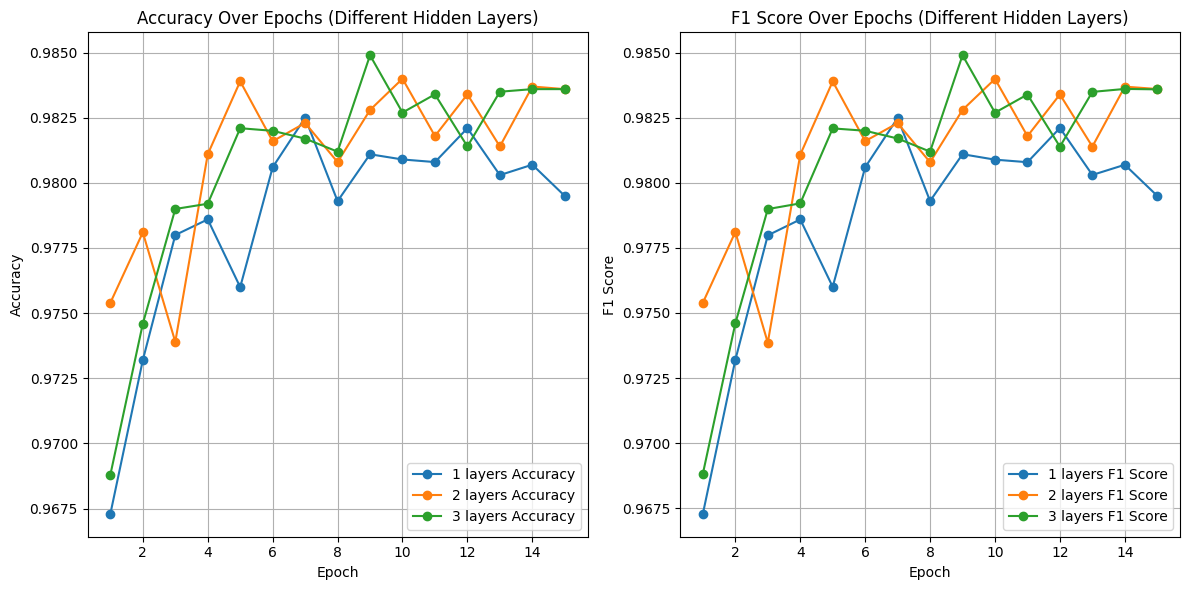

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Modified MLP model with optional batch normalization and dropout removal
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_fn=torch.nn.ReLU, use_batchnorm=True):
        super(MLP, self).__init__()
        layers = []

        # Input to first hidden layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        if use_batchnorm:
            layers.append(nn.BatchNorm1d(hidden_sizes[0]))  # Adding BatchNorm
        layers.append(activation_fn())

        # Add additional hidden layers
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_sizes[i]))  # Adding BatchNorm
            layers.append(activation_fn())

        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Function to train and evaluate with different hidden layer configurations
def train_and_evaluate_with_hidden_layers(train_loader, eval_loader, criterion, input_size, hidden_layers_configs, output_size, learning_rate=1e-03, epochs=15):  # Reduced learning rate

    # Dictionary to store results
    all_accuracies = {}
    all_f1_scores = {}

    for hidden_sizes in hidden_layers_configs:
        print(f"Training model with {len(hidden_sizes)} hidden layers: {hidden_sizes}")

        model = MLP(input_size, hidden_sizes, output_size).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Lower learning rate to 1e-03

        # Train and evaluate the model
        epoch_steps, accuracies, f1_scores = train_and_evaluate_with_dropout(model, train_loader, eval_loader, criterion, optimizer, dropout_rate=0.1, epochs=epochs)  # No dropout

        # Store results for each hidden layer configuration
        all_accuracies[f'{len(hidden_sizes)} layers'] = accuracies
        all_f1_scores[f'{len(hidden_sizes)} layers'] = f1_scores

    # Plot the results
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot accuracy
    for label in all_accuracies:
        ax[0].plot(epoch_steps, all_accuracies[label], label=f'{label} Accuracy', marker='o')

    # Plot F1 score
    for label in all_f1_scores:
        ax[1].plot(epoch_steps, all_f1_scores[label], label=f'{label} F1 Score', marker='o')

    # Customize the accuracy plot
    ax[0].set_title('Accuracy Over Epochs (Different Hidden Layers)')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[0].grid(True)

    # Customize the F1 score plot
    ax[1].set_title('F1 Score Over Epochs (Different Hidden Layers)')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('F1 Score')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

# Hidden layer configurations for ablation study (1, 2, and 3 hidden layers with larger neurons)
hidden_layers_configs = [
    [256],         # 1 hidden layer with 256 neurons
    [512, 256],    # 2 hidden layers with more neurons
    [512, 256, 128] # 3 hidden layers with even more capacity
]

# Example call for the ablation study with different hidden layers
train_and_evaluate_with_hidden_layers(train_loader, eval_loader, criterion, input_size=784, hidden_layers_configs=hidden_layers_configs, output_size=10, learning_rate=1e-03, epochs=15)
